# Predicción a 5 dias importando el modelo

## bibliotecas


In [1]:
# ==============================
# Libreries
# ==============================
import pandas as pd
import numpy as np
import random
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import time

### configuración

In [2]:
# ==============================
# PARTE 1 — Configuración Inicial y Carga de Datos
# ==============================

# ------------------------------
# 1. Fijar semilla para reproducibilidad
# ------------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# ------------------------------
# 2. Cargar dataset final y poner 'Date' como índice
# ------------------------------
data_path = "../../data/processed/final_data.csv.gz"
data = pd.read_csv(data_path, compression='gzip', parse_dates=['Date'], index_col='Date')

print("Columnas del dataset:", list(data.columns))
print(f"Dimensiones dataset original: {data.shape}")

# ------------------------------
# 3. Filtrar rango temporal
# ------------------------------
start_date = "2005-01-01"
end_date = "2025-10-31"
data = data.loc[start_date:end_date]

print(f"Dimensiones dataset filtrado 2005-2025: {data.shape}")

# ------------------------------
# 4. Seleccionar columnas principales
# ------------------------------
# Columnas de interés para la RNN: precios BBVA, Santander y PCA
pca_cols = [col for col in data.columns if "PCA" in col]
main_cols = ['BBVA.MC_Close', 'SAN.MC_Close'] + pca_cols

data_rnn = data[main_cols]
print(f"Columnas seleccionadas para la RNN: {data_rnn.shape[1]}")

# ------------------------------
# 5. Visualización rápida
# ------------------------------
display(data_rnn)

Columnas del dataset: ['SAN.MC_Close', 'BKT.MC_Low', 'STOXX50E_Low', 'STOXX50E_Open', 'HSBC_Low', 'UNI.MC_Open', 'HSBC_Open', 'EURJPY.csv_Close', 'ECB_M3_SKK', 'IBEX_High', 'BBVA.MC_Low', 'MSCI_Financials.csv_High', 'IBEX_Close', 'SAB.MC_Low', 'UNI.MC_Low', 'EURJPY.csv_Open', 'UNI.MC_High', 'GDAXI_Close', 'URTH_Low', 'URTH_Close', 'GDAXI_Open', 'STOXX50E_Close', 'STOXX50E_High', 'BBVA.MC_Open', 'BKT.MC_Open', 'N225_Open', 'ECB_M3_HKD', 'FTSE_Close', 'EURJPY.csv_Low', 'FTSE_Low', 'UNI.MC_Close', 'JPM_Open', 'IBEX_Low', 'BKT.MC_Close', 'URTH_Open', 'HSBC_Close', 'ECB_M3_USD', 'GDAXI_Low', 'GDAXI_High', 'CABK.MC_Close', 'JPM_Close', 'SAB.MC_Close', 'SAB.MC_High', 'JPM_High', 'SAN.MC_Low', 'MSCI_Financials.csv_Open', 'FTSE_Open', 'BBVA.MC_Close', 'ECB_M3_CZK', 'FTSE_High', 'BBVA.MC_High', 'BKT.MC_High', 'EURJPY.csv_High', 'N225_High', 'SAN.MC_Open', 'MSCI_Financials.csv_Close', 'MSCI_Financials.csv_Low', 'N225_Close', 'URTH_High', 'IBEX_Open', 'ECB_M3_JPY', 'CABK.MC_High', 'CABK.MC_Open', 

,BBVA.MC_Close,SAN.MC_Close,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,...,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,NaN,NaN,-1.826990,9.380348,-1.741290,3.502204,-0.836790,3.841229,-5.521703,-1.800316,...,0.557657,0.282267,-0.342419,0.156220,-0.129392,0.314089,-0.252011,-1.024318,0.424503,-0.375780
2005-01-02,NaN,NaN,-1.829039,9.372219,-1.740167,3.499036,-0.836139,3.838251,-5.517482,-1.798937,...,0.556834,0.281893,-0.341843,0.155771,-0.129330,0.313644,-0.251855,-1.022809,0.423520,-0.375943
2005-01-03,4.446411,2.599646,13.872782,11.112143,-3.493010,-2.724641,0.472894,-2.873407,-4.582791,1.332656,...,2.515268,1.295396,-1.021902,0.445984,0.216710,-0.171002,0.269162,0.382764,0.353047,-0.440628
2005-01-04,4.422707,2.599646,14.893037,11.396897,-3.324143,-4.069852,0.663474,-2.580715,-5.022860,2.046954,...,1.853438,1.007899,-1.303535,-1.117715,1.556725,-1.142550,0.401012,0.559087,-0.074189,0.690906
2005-01-05,4.399001,2.562912,14.396275,11.309068,-3.677995,-3.095892,0.531848,-2.974937,-4.570563,1.700930,...,2.607476,1.358329,-1.250671,0.216616,0.716502,-0.387861,0.256955,0.455559,0.370632,-0.141541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-29,17.580000,8.865000,28.104901,-13.234004,-7.846998,9.143141,-0.996252,-5.593029,1.942455,-4.821068,...,-1.417439,0.270332,-0.035416,-3.233211,3.800043,-1.273700,1.316176,-4.846464,-0.938750,-0.844075
2025-10-30,17.280001,8.750000,27.821980,-12.739586,-7.443427,8.330550,-0.781672,-5.817917,1.940370,-5.307145,...,-0.837936,0.501435,0.858817,-5.682608,0.919306,0.624927,0.554233,-4.628295,-0.080748,-0.642446
2025-10-30,17.280001,8.750000,27.762862,-12.795248,-7.422621,8.325187,-0.777465,-5.887823,1.912897,-5.162755,...,-0.739295,0.549786,0.778913,-5.656696,0.947402,0.721576,0.793313,-4.729327,-0.076427,-0.544759


In [3]:
# ==============================
# PARTE 2 — Preprocesamiento y Preparación de Secuencias (TF)
# ==============================

# ------------------------------
# 1. Forward-fill / Backward-fill por si hay NaN
# ------------------------------
data_rnn = data_rnn.ffill().bfill()

# ------------------------------
# 2. Escalado de datos
# ------------------------------
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_rnn), 
                           columns=data_rnn.columns, index=data_rnn.index)

# ------------------------------
# 3. Función para crear secuencias
# ------------------------------
def create_sequences(data, target_cols=['BBVA.MC_Close', 'SAN.MC_Close'], 
                     lookback=5, horizon=1):
    X, y = [], []
    for i in range(lookback, len(data) - horizon + 1):
        X_seq = data.iloc[i - lookback:i].values
        y_seq = data.iloc[i:i + horizon][target_cols].values  # multi-step support
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)

# ------------------------------
# 4. Crear secuencias para single-step y multi-step
# ------------------------------
lookback = 5  # t-1 a t-5

# Single-step (1 día adelante)
horizon = 1
X_1, y_1 = create_sequences(data_scaled, lookback=lookback, horizon=horizon)

# Multi-step (5 días adelante)
horizon = 5
X_5, y_5 = create_sequences(data_scaled, lookback=lookback, horizon=horizon)

# ------------------------------
# 5. Información de shapes
# ------------------------------
print("Single-step prediction:")
print("X_1.shape:", X_1.shape)  # (samples, 5, n_features)
print("y_1.shape:", y_1.shape)  # (samples, 1, target_cols)

print("\nMulti-step prediction (5 días):")
print("X_5.shape:", X_5.shape)
print("y_5.shape:", y_5.shape)

# ------------------------------
# Crear vector de fechas correspondiente a cada secuencia
# ------------------------------
dates_all_1 = data_scaled.index[lookback : len(data_scaled) - 1 + 1]  # para X_1, single-step
dates_all_5 = data_scaled.index[lookback : len(data_scaled) - 5 + 1]  # para X_5, multi-step 5 días


Single-step prediction:
X_1.shape: (9520, 5, 24)
y_1.shape: (9520, 1, 2)

Multi-step prediction (5 días):
X_5.shape: (9516, 5, 24)
y_5.shape: (9516, 5, 2)


In [4]:
display(data_scaled)

,BBVA.MC_Close,SAN.MC_Close,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,...,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,-0.317987,-0.848228,-1.358612,1.034835,-0.799572,0.591331,-0.149875,1.064762,-3.129804,-0.619318,...,0.424398,0.195495,-0.265098,0.057354,0.007225,0.216878,0.060512,-0.802750,0.384390,-0.203940
2005-01-02,-0.317987,-0.848228,-1.358793,1.034010,-0.799317,0.590667,-0.149740,1.063930,-3.127409,-0.618863,...,0.423959,0.195316,-0.264803,0.057127,0.007257,0.216649,0.060607,-0.801809,0.383783,-0.204064
2005-01-03,-0.317987,-0.848228,0.031795,1.210631,-1.197809,-0.714320,0.121685,-0.811318,-2.597119,0.416147,...,1.469783,0.681576,-0.612962,0.203968,0.186518,-0.033172,0.378494,0.074182,0.340327,-0.253016
2005-01-04,-0.326732,-0.848228,0.122151,1.239537,-1.159419,-0.996385,0.161202,-0.729539,-2.846789,0.652227,...,1.116359,0.543640,-0.757146,-0.587227,0.880694,-0.533976,0.458939,0.184072,0.076875,0.603309
2005-01-05,-0.335478,-0.880170,0.078157,1.230621,-1.239864,-0.792164,0.133909,-0.839685,-2.590182,0.537864,...,1.519023,0.711771,-0.730082,0.087913,0.445429,-0.144956,0.371046,0.119550,0.351170,-0.026672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-29,4.527693,4.599720,1.292224,-1.260770,-2.187647,1.774128,-0.182939,-1.571184,1.104929,-1.617695,...,-0.630324,0.189769,-0.107927,-1.657619,2.042812,-0.601580,1.017306,-3.184816,-0.456249,-0.558338
2025-10-30,4.417007,4.499723,1.267168,-1.210581,-2.095899,1.603743,-0.138446,-1.634019,1.103746,-1.778346,...,-0.320863,0.300648,0.349880,-2.896957,0.550488,0.377105,0.552424,-3.048848,0.072831,-0.405748
2025-10-30,4.417007,4.499723,1.261932,-1.216231,-2.091168,1.602619,-0.137574,-1.653550,1.088160,-1.730624,...,-0.268188,0.323846,0.308973,-2.883846,0.565043,0.426925,0.698293,-3.111813,0.075495,-0.331821


### carga modelo

In [ ]:
# # ===============================
# # 1️⃣ Cargar modelo entrenado
# # ===============================
# from tensorflow.keras.models import load_model
# model = load_model(r"..\..\results\models\lstm_256_128_drop0.3_0.2_bs32_final.keras", compile=False)

# # ===============================
# # 2️⃣ Preparar datos de validación (igual que en el entrenamiento)
# # ===============================
# X = X_1
# y = y_1.reshape(y_1.shape[0], y_1.shape[2])

# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val, dates_train, dates_val = train_test_split(
#     X, y, dates_all_1, test_size=0.2, random_state=SEED
# )

# # ===============================
# # 3️⃣ Predicción
# # ===============================
# y_pred = model.predict(X_val)  # (samples, 2)

# # ===============================
# # 4️⃣ Invertir escalado
# # ===============================
# from sklearn.preprocessing import StandardScaler
# scaler_target = StandardScaler()
# scaler_target.fit(data_rnn[['BBVA.MC_Close', 'SAN.MC_Close']])

# y_val_inv  = scaler_target.inverse_transform(y_val)
# y_pred_inv = scaler_target.inverse_transform(y_pred)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [ ]:
# ==============================
# 1️⃣ Cargar modelo entrenado
# ==============================
from tensorflow.keras.models import load_model
model = load_model(r"..\..\results\models\lstm_256_128_drop0.3_0.2_bs32_final.keras", compile=False)

# ==============================
# 2️⃣ Preparar datos completos para predicción
# ==============================
X = X_1
y = y_1.reshape(y_1.shape[0], y_1.shape[2])  # (samples, 2)
dates_seq = dates_all_1

# ==============================
# 3️⃣ Predicción sobre todos los datos
# ==============================
y_pred_scaled = model.predict(X)

# ==============================
# 4️⃣ Predicción N días hacia adelante usando la última ventana
# ==============================
import numpy as np
import pandas as pd

n_future = 5
last_X = X[-1:].copy()
future_preds_scaled = []

for _ in range(n_future):
    pred_scaled = model.predict(last_X, verbose=0)
    future_preds_scaled.append(pred_scaled[0])
    new_step = last_X[:, -1, :].copy()
    new_step[0, 0:2] = pred_scaled
    last_X = np.concatenate([last_X[:, 1:, :], new_step.reshape(1,1,-1)], axis=1)

future_preds_scaled = np.array(future_preds_scaled)

## predicción 5 dias

298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


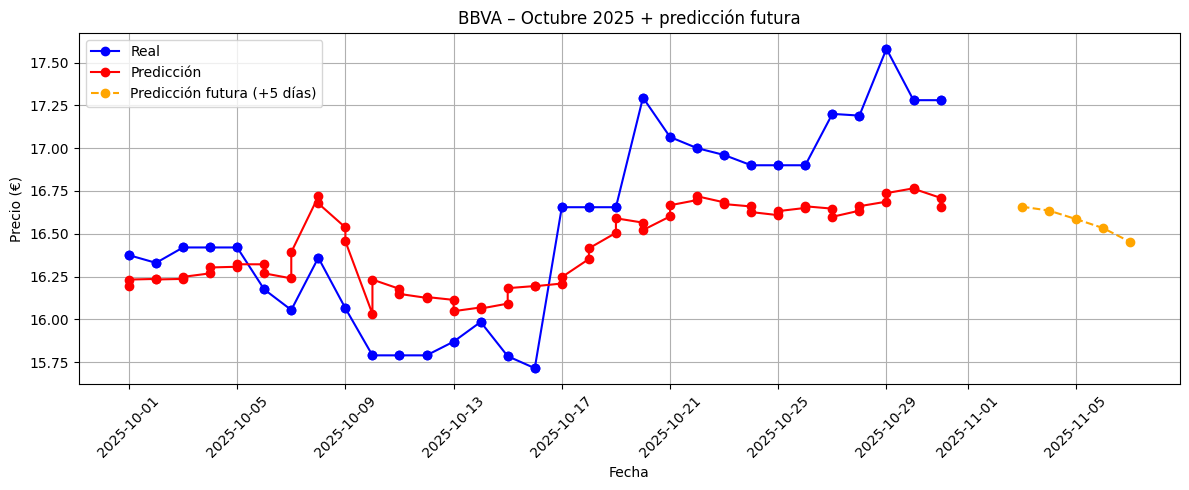

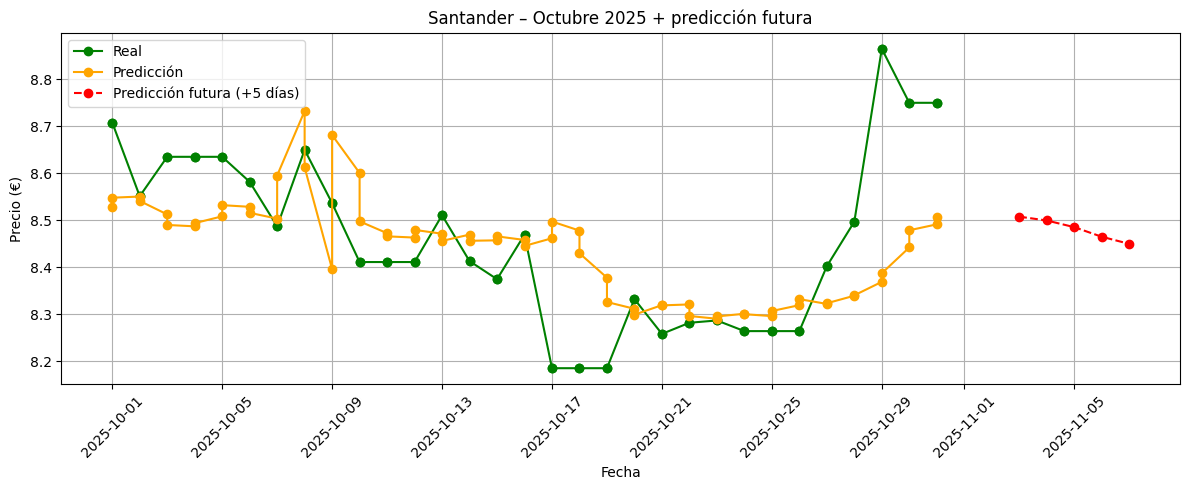

In [ ]:

# ==============================
# 5️⃣ Desescalar todo
# ==============================
from sklearn.preprocessing import StandardScaler

scaler_target = StandardScaler()
scaler_target.fit(data_rnn[['BBVA.MC_Close', 'SAN.MC_Close']])

y_pred_inv = scaler_target.inverse_transform(y_pred_scaled)
future_preds_inv = scaler_target.inverse_transform(future_preds_scaled)
y_inv = scaler_target.inverse_transform(y)

# ==============================
# 6️⃣ Crear DataFrames completos
# ==============================
df_val_bbva = pd.DataFrame({
    'date': dates_seq,
    'y_real': y_inv[:,0],
    'y_pred': y_pred_inv[:,0]
})

df_val_san = pd.DataFrame({
    'date': dates_seq,
    'y_real': y_inv[:,1],
    'y_pred': y_pred_inv[:,1]
})

# Fechas futuras
last_date = df_val_bbva['date'].max()
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=n_future)

df_future_bbva = pd.DataFrame({'date': future_dates, 'pred': future_preds_inv[:,0]})
df_future_san  = pd.DataFrame({'date': future_dates, 'pred': future_preds_inv[:,1]})

# ==============================
# 7️⃣ Filtrar solo Octubre 2025 para impresión y gráficos
# ==============================
oct_start, oct_end = pd.Timestamp('2025-10-01'), pd.Timestamp('2025-10-31')
df_oct_bbva = df_val_bbva[(df_val_bbva['date'] >= oct_start) & (df_val_bbva['date'] <= oct_end)]
df_oct_san  = df_val_san[(df_val_san['date'] >= oct_start) & (df_val_san['date'] <= oct_end)]

# ==============================
# 8️⃣ Gráficos del último mes + 5 días futuros
# ==============================
import matplotlib.pyplot as plt

def annotate_prices(ax, x, y, color):
    for i, val in enumerate(y):
        ax.text(i, val, f"{val:.2f}", color=color, fontsize=8, ha='center', va='bottom')

# --- BBVA ---
plt.figure(figsize=(12,5))
plt.plot(df_oct_bbva['date'], df_oct_bbva['y_real'], label='Real', color='blue', marker='o')
plt.plot(df_oct_bbva['date'], df_oct_bbva['y_pred'], label='Predicción', color='red', marker='o')

# Filtrar solo futuros que estén después del último día de Octubre
df_future_oct_bbva = df_future_bbva[df_future_bbva['date'] > oct_end]
plt.plot(df_future_oct_bbva['date'], df_future_oct_bbva['pred'], 
         label=f'Predicción futura (+{n_future} días)', color='orange', marker='o', linestyle='--')

plt.title('BBVA – Octubre 2025 + predicción futura')
plt.xlabel('Fecha')
plt.ylabel('Precio (€)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- SANTANDER ---
plt.figure(figsize=(12,5))
plt.plot(df_oct_san['date'], df_oct_san['y_real'], label='Real', color='green', marker='o')
plt.plot(df_oct_san['date'], df_oct_san['y_pred'], label='Predicción', color='orange', marker='o')

df_future_oct_san = df_future_san[df_future_san['date'] > oct_end]
plt.plot(df_future_oct_san['date'], df_future_oct_san['pred'], 
         label=f'Predicción futura (+{n_future} días)', color='red', marker='o', linestyle='--')

plt.title('Santander – Octubre 2025 + predicción futura')
plt.xlabel('Fecha')
plt.ylabel('Precio (€)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### otra prueba

298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


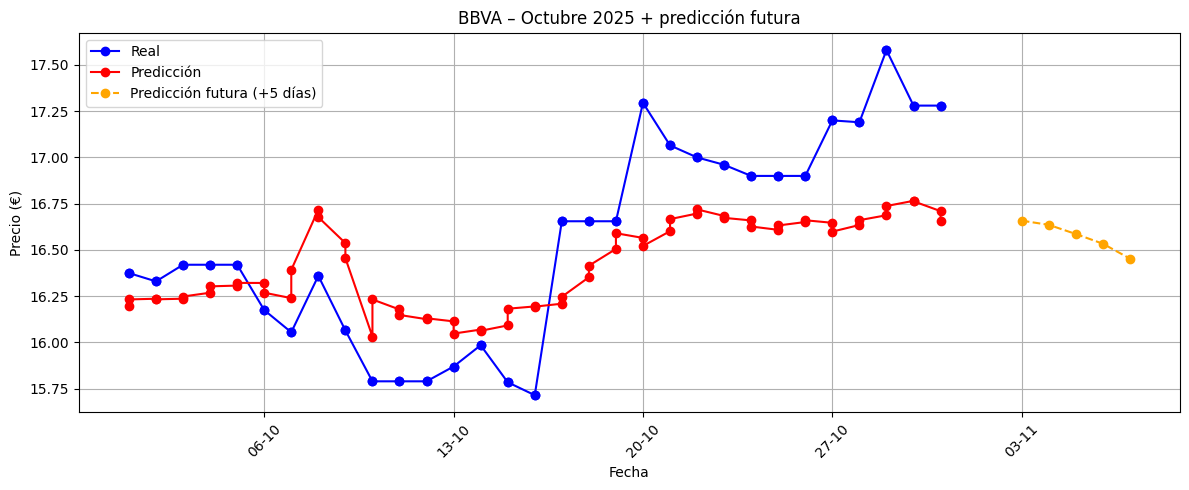

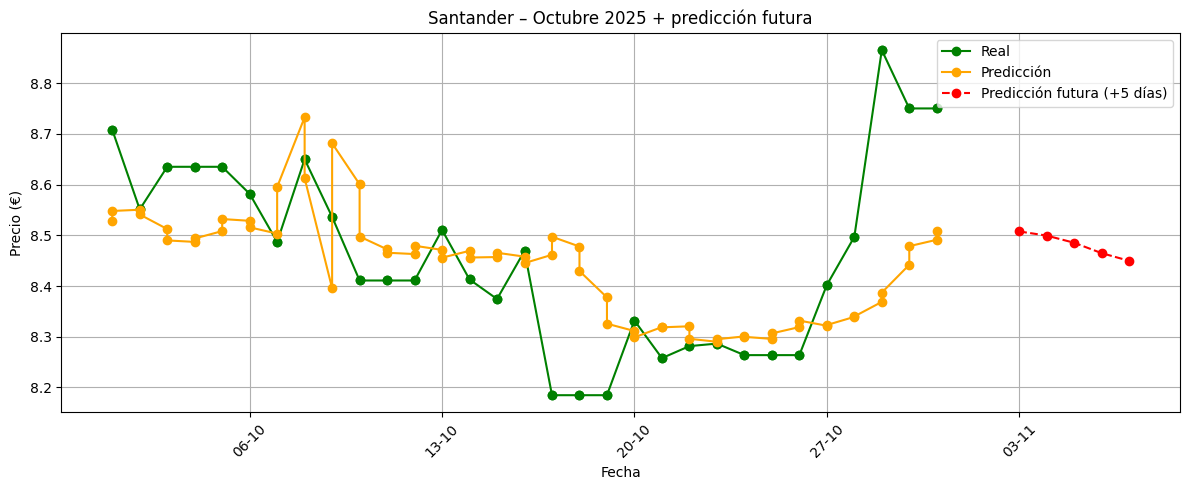


Predicción futura BBVA:
        date       pred trend
0 2025-11-03  16.658154   N/A
1 2025-11-04  16.635662  Baja
2 2025-11-05  16.586023  Baja
3 2025-11-06  16.533602  Baja
4 2025-11-07  16.453152  Baja

Predicción futura Santander:
        date      pred trend
0 2025-11-03  8.507558   N/A
1 2025-11-04  8.499381  Baja
2 2025-11-05  8.485217  Baja
3 2025-11-06  8.464777  Baja
4 2025-11-07  8.449652  Baja


In [ ]:
# ==============================
# 1️⃣ Cargar modelo entrenado
# ==============================
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler

model = load_model(r"..\..\results\models\lstm_256_128_drop0.3_0.2_bs32_final.keras", compile=False)

# ==============================
# 2️⃣ Preparar datos completos para predicción
# ==============================
X = X_1
y = y_1.reshape(y_1.shape[0], y_1.shape[2])  # (samples, 2)
dates_seq = dates_all_1

# ==============================
# 3️⃣ Predicción sobre todos los datos
# ==============================
y_pred_scaled = model.predict(X)

# ==============================
# 4️⃣ Predicción N días hacia adelante usando la última ventana
# ==============================
n_future = 5
last_X = X[-1:].copy()
future_preds_scaled = []

for _ in range(n_future):
    pred_scaled = model.predict(last_X, verbose=0)
    future_preds_scaled.append(pred_scaled[0])
    new_step = last_X[:, -1, :].copy()
    new_step[0, 0:2] = pred_scaled
    last_X = np.concatenate([last_X[:, 1:, :], new_step.reshape(1,1,-1)], axis=1)

future_preds_scaled = np.array(future_preds_scaled)

# ==============================
# 5️⃣ Desescalar todo
# ==============================
scaler_target = StandardScaler()
scaler_target.fit(data_rnn[['BBVA.MC_Close', 'SAN.MC_Close']])

y_pred_inv = scaler_target.inverse_transform(y_pred_scaled)
future_preds_inv = scaler_target.inverse_transform(future_preds_scaled)
y_inv = scaler_target.inverse_transform(y)

# ==============================
# 6️⃣ Crear DataFrames completos
# ==============================
df_val_bbva = pd.DataFrame({
    'date': dates_seq,
    'y_real': y_inv[:,0],
    'y_pred': y_pred_inv[:,0]
})

df_val_san = pd.DataFrame({
    'date': dates_seq,
    'y_real': y_inv[:,1],
    'y_pred': y_pred_inv[:,1]
})

# Fechas futuras (solo laborables)
last_date = df_val_bbva['date'].max()
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=n_future)

df_future_bbva = pd.DataFrame({'date': future_dates, 'pred': future_preds_inv[:,0]})
df_future_san  = pd.DataFrame({'date': future_dates, 'pred': future_preds_inv[:,1]})

# ==============================
# 7️⃣ Filtrar solo Octubre 2025 para impresión y gráficos
# ==============================
oct_start, oct_end = pd.Timestamp('2025-10-01'), pd.Timestamp('2025-10-31')
df_oct_bbva = df_val_bbva[(df_val_bbva['date'] >= oct_start) & (df_val_bbva['date'] <= oct_end)]
df_oct_san  = df_val_san[(df_val_san['date'] >= oct_start) & (df_val_san['date'] <= oct_end)]

# ==============================
# 8️⃣ Calcular subida/bajada de la predicción futura
# ==============================
# Función: compara cada predicción con la anterior (predicción, no valor real)
def compute_trend(preds):
    trend = []
    for i in range(len(preds)):
        if i == 0:
            trend.append("N/A")  # primer día no tiene referencia
        else:
            trend.append("Sube" if preds[i] > preds[i-1] else "Baja")
    return trend

df_future_bbva['trend'] = compute_trend(df_future_bbva['pred'])
df_future_san['trend']  = compute_trend(df_future_san['pred'])

# ==============================
# 9️⃣ Función para anotar precios
# ==============================
def annotate_prices(ax, x, y, color):
    for i, val in enumerate(y):
        ax.text(i, val, f"{val:.2f}", color=color, fontsize=8, ha='center', va='bottom')

# ==============================
# 10️⃣ Gráficos del último mes + 5 días futuros
# ==============================
# --- BBVA ---
plt.figure(figsize=(12,5))
plt.plot(df_oct_bbva['date'], df_oct_bbva['y_real'], label='Real', color='blue', marker='o')
plt.plot(df_oct_bbva['date'], df_oct_bbva['y_pred'], label='Predicción', color='red', marker='o')
plt.plot(df_future_bbva['date'], df_future_bbva['pred'], 
         label=f'Predicción futura (+{n_future} días)', color='orange', marker='o', linestyle='--')

plt.title('BBVA – Octubre 2025 + predicción futura')
plt.xlabel('Fecha')
plt.ylabel('Precio (€)')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  # solo lunes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Santander ---
plt.figure(figsize=(12,5))
plt.plot(df_oct_san['date'], df_oct_san['y_real'], label='Real', color='green', marker='o')
plt.plot(df_oct_san['date'], df_oct_san['y_pred'], label='Predicción', color='orange', marker='o')
plt.plot(df_future_san['date'], df_future_san['pred'], 
         label=f'Predicción futura (+{n_future} días)', color='red', marker='o', linestyle='--')

plt.title('Santander – Octubre 2025 + predicción futura')
plt.xlabel('Fecha')
plt.ylabel('Precio (€)')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  # solo lunes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==============================
# 11️⃣ Imprimir predicción futura con tendencia
# ==============================
print("\nPredicción futura BBVA:")
print(df_future_bbva[['date', 'pred', 'trend']])
print("\nPredicción futura Santander:")
print(df_future_san[['date', 'pred', 'trend']])

#### hacer

1. esta prediciendo realmente el 1,2,3,4,5 o 3,4,5,6,7 
2. hacer una prediccion para cada caso: una grafica de bbva y santander para 1,2,3,4,5 y otra 3,4,5,6,7 

    2.1. para el caso de que prediga el fin de semana, en un grafica ponerlo y en otro no. es decir, predecir:

            - 1,2,3,4,5
            - 3,4,5 
            - 3,4,5,6,7


3. en los nombres de las x poner todos los valores

4. que % baja respecto al dia anterior?

## elegir el mes exacto

In [ ]:
def plot_monthly_comparison(df_bbva, df_san, year, month):
    import pandas as pd
    import matplotlib.pyplot as plt
    import calendar

    # ===============================
    # 1️⃣ Rango del mes seleccionado
    # ===============================
    last_day = calendar.monthrange(year, month)[1]
    month_start = pd.Timestamp(year=year, month=month, day=1)
    month_end   = pd.Timestamp(year=year, month=month, day=last_day)

    # ===============================
    # 2️⃣ Filtrar solo datos del mes
    # ===============================
    df_bbva_sel = df_bbva[(df_bbva['date'] >= month_start) & (df_bbva['date'] <= month_end)].copy()
    df_san_sel  = df_san[(df_san['date'] >= month_start) & (df_san['date'] <= month_end)].copy()

    # Eliminar duplicados dejando la media de cada fecha
    df_bbva_sel = df_bbva_sel.groupby('date', as_index=False).mean(numeric_only=True)
    df_san_sel  = df_san_sel.groupby('date', as_index=False).mean(numeric_only=True)

    # ===============================
    # 3️⃣ Reindexar SOLO con días hábiles
    # ===============================
    business_days = pd.bdate_range(start=month_start, end=month_end)

    df_bbva_sel = df_bbva_sel.set_index('date').reindex(business_days).ffill().reset_index()
    df_san_sel  = df_san_sel.set_index('date').reindex(business_days).ffill().reset_index()

    df_bbva_sel.rename(columns={'index': 'date'}, inplace=True)
    df_san_sel.rename(columns={'index': 'date'}, inplace=True)

    # Crear etiquetas personalizadas para eje X
    df_bbva_sel['day_str'] = df_bbva_sel['date'].dt.strftime('%d-%b')  # ejemplo: 01-Oct
    df_san_sel['day_str']  = df_san_sel['date'].dt.strftime('%d-%b')

    # ===============================
    # 4️⃣ Gráfico BBVA
    # ===============================
    plt.figure(figsize=(12,5))
    plt.plot(df_bbva_sel['day_str'], df_bbva_sel['y_real'], label='BBVA Real', color='blue')
    plt.plot(df_bbva_sel['day_str'], df_bbva_sel['y_pred'], label='BBVA Predicción', color='red')
    plt.title(f'BBVA - {month_start.strftime("%B %Y")}: Predicción vs Real (días hábiles)')
    plt.xlabel('Fecha')
    plt.ylabel('Valor (€)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ===============================
    # 5️⃣ Gráfico Santander
    # ===============================
    plt.figure(figsize=(12,5))
    plt.plot(df_san_sel['day_str'], df_san_sel['y_real'], label='Santander Real', color='green')
    plt.plot(df_san_sel['day_str'], df_san_sel['y_pred'], label='Santander Predicción', color='orange')
    plt.title(f'Santander - {month_start.strftime("%B %Y")}: Predicción vs Real (días hábiles)')
    plt.xlabel('Fecha')
    plt.ylabel('Valor (€)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


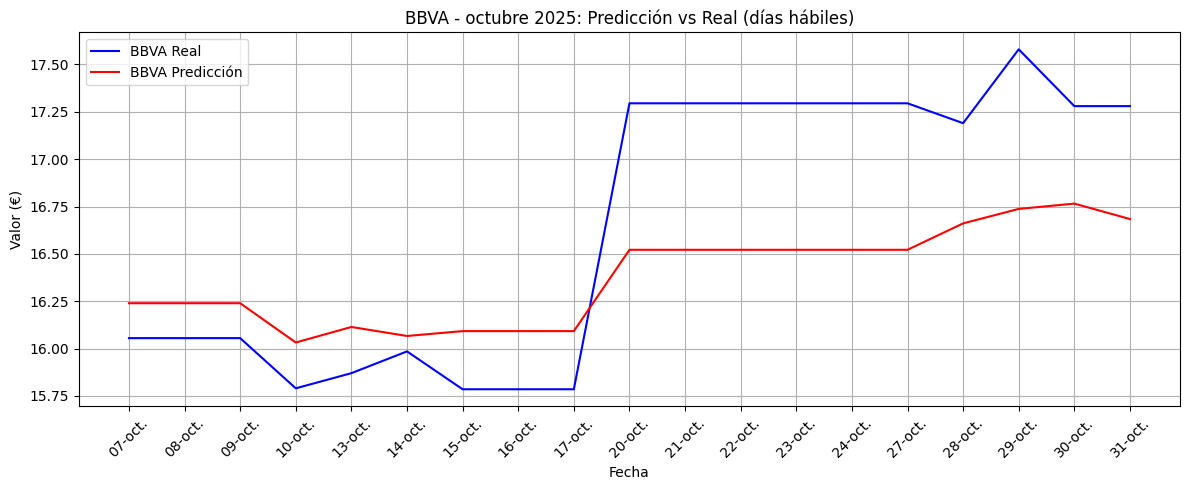

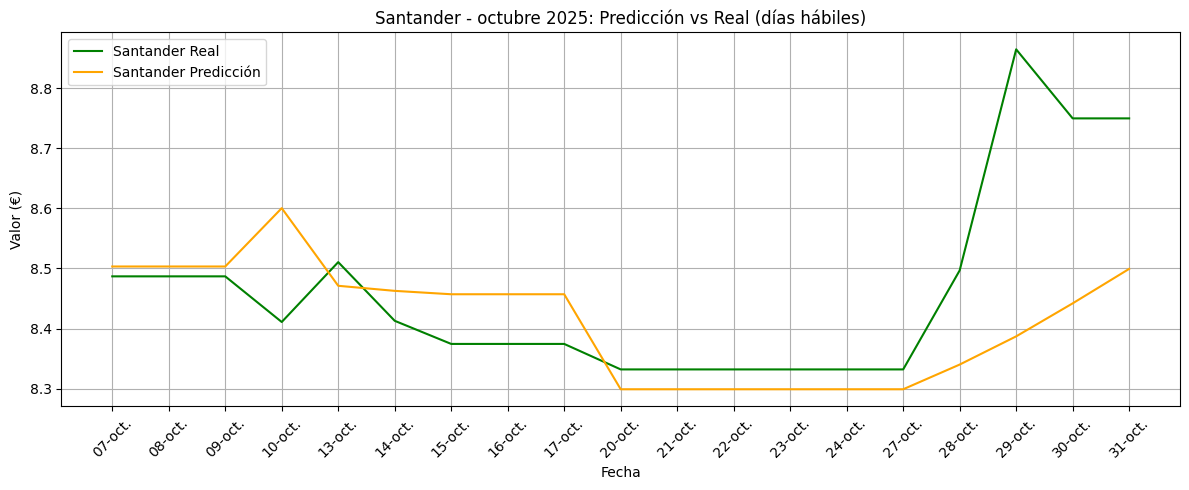

In [ ]:
plot_monthly_comparison(df_val_bbva_inv, df_val_san_inv, 2025, 10)